# Example: Neural Networks – Relaxing walk

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Random
using Gogeta
using Gurobi
using JuMP
using Plots
using Revise
using QuasiMonteCarlo
using Images, FileIO

In this example, we are going to introduce the function `optimize_by_walking!()` that can be used to optimize MILP formulation of the neural network faster than optimizing the formulation directly. To understand the method in detail, see Tong, J et al. (2024)

## Innitialize neural network with random weights

In [2]:
dimension = 2

begin
    Random.seed!(12345);

    NN_model = Chain(
        Dense(dimension => 100, relu),
        Dense(100 => 100, relu),
        Dense(100 => 1)
    )
end

Chain(
  Dense(2 => 100, relu),                # 300 parameters
  Dense(100 => 100, relu),              # 10_100 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 6 arrays, 10_501 parameters, 41.395 KiB.

## Formulate  NN as a MILP 

We set up upper and lower bounds for the variables in which our MILP formulation is guranteed to output the same values as the original NN

In [4]:
init_U = [5.0, 5.0];
init_L = [-5.0, -5.0];

Formulate MILP model with fast bound tightening. Set objective funciton of the model as a maximiztion of the output neuron.

In [5]:
# Formulate the MIP with heuristic bound tightening
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)
NN_formulate!(jump_model, NN_model, init_U, init_L; bound_tightening="fast");

last_layer, _ = maximum(keys(jump_model[:x].data))
@objective(jump_model, Max, jump_model[:x][last_layer, 1])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


x[3,1]

In [6]:
x_range = LinRange{Float32}(init_L[1], init_U[1], 50);
y_range = LinRange{Float32}(init_L[2], init_U[2], 50);

f_himmelblau(x, y) = ((x^2+y-11)^2 + (x+y^2-7)^2)
f(x, y) = -log(f_himmelblau(x, y))

f (generic function with 1 method)

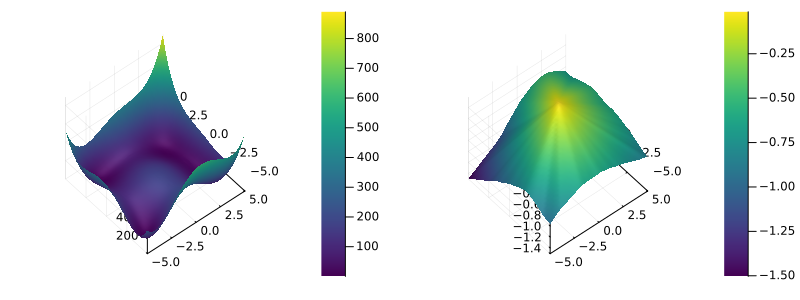

In [7]:
c_1 = plot(x_range, y_range, f_himmelblau, st=:surface, c=cgrad(:viridis), camera=(-40, 50))
c_3 = plot(x_range, y_range, (x, y) -> NN_model(hcat(x, y)')[], st=:surface, c=cgrad(:viridis), camera=(-40, 50))

plot(c_1, c_3, layout=(1, 2), size=(800, 300))

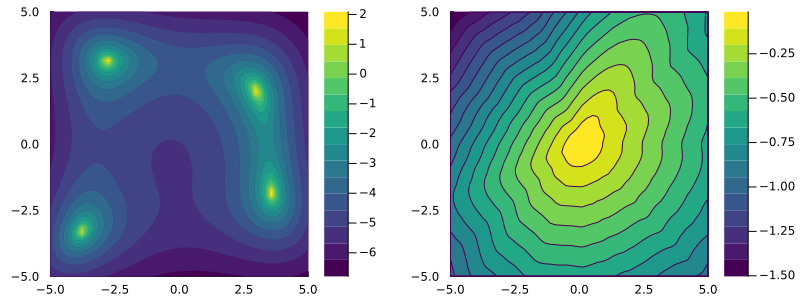

In [8]:
c_2 = plot(x_range, y_range, f, st=:contourf, c=cgrad(:viridis), lw=0)
c_4 = plot(x_range, y_range, (x, y) -> NN_model(hcat(x, y)')[], st=:contourf, c=cgrad(:viridis), camera=(-40, 50))
plot(c_2, c_4, layout=(1, 2), size=(800, 300))

In [11]:
relax_integrality(jump_model)
plot(x_range, y_range, (x, y) -> forward_pass!(jump_model, [x,y])[], st=:contourf, c=cgrad(:viridis), camera=(-40, 50))

i = 1

if isdir("frames")
    rm("frames", recursive=true)
end 

mkdir("frames")

for x in range(-2.9, 2.9, 10), y in range(-2.9, 2.9, 10)
    _, _, path = local_search([x, y], jump_model, init_U, init_L; show_path=true)
    heights = [NN_model(path[i])[] for i in eachindex(path)]
    plotd = plot!(first.(path), last.(path), heights .+ 0.1, marker=:circle, legend=false, lw=3)
    savefig(plotd,"frames/frame_$i.png")
    i+=1
end


In [12]:
# Load images
image_files = ["frames/frame_$j.png" for j in 1:i-1]
images = [load(file) for file in image_files]
rm("frames", recursive=true)
# Create and save the GIF
save("animation.gif", cat(images..., dims=3))

![alt text](animation.gif)

`set_solver!()` should be specified

In [61]:
function set_solver!(jump)
    set_optimizer(jump, Gurobi.Optimizer)
    set_silent(jump)
end

set_solver! (generic function with 1 method)

In [ ]:
Pkg.instantiate()

In [125]:

function optimize_by_walking1(original::JuMP.Model, nn_model::Flux.Chain, U_in, L_in; delta=0.1, return_sampled=false, logging=true, iterations=10, infeasible_per_iter=5)

    sample(items, weights) = items[findfirst(cumsum(weights) .> rand() * sum(weights))]
    
    opt_time = 0.0
    search_time = 0.0

    n_layers, _ = maximum(keys(original[:x].data))
    
    x_opt = Vector{Vector}() # list of locally optimum solutions
    opt = Vector{Float64}()
    sampled_points = Vector{Vector}()

    # copy model
    jump_model = JuMP.copy(original)
    Main.set_solver!(jump_model)

    # get LP solution
    relax_integrality(jump_model)
    opt_time += @elapsed optimize!(jump_model)

    x_tilde = [value(jump_model[:x][0, i]) for i in 1:length(U_in)]
    z_tilde = value.(jump_model[:z])

    println(x_tilde)

    push!(sampled_points, x_tilde)
    
    local_opt, opt_value = local_search(x_tilde, original, U_in, L_in,  logging=true)
    push!(x_opt, local_opt)
    push!(opt, opt_value)

    for iter in 1:iterations # TODO time limit based termination

        logging && println("\n\nIteration: $iter")
        infeasible_count = 0

        x_bar = deepcopy(x_tilde)
        z_bar = deepcopy(z_tilde)

        # determine active neurons
        binary_vars = keys(original[:z].data)
        values_flux = [map(n -> n > 0 ? 1.0 : 0.0, nn_model[1:layer](Float32.(x_bar))) for layer in unique(first.(binary_vars))]
        active = filter(key -> values_flux[key[1]][key[2]] == 1.0, binary_vars)

        for layer in 1:(n_layers-1) # hidden layers

            logging && println("\n--------------Layer: $layer--------------")

            n_neurons = first(maximum(keys(original[:x][layer, :].data)))
            neurons = Set(1:n_neurons)

            while isempty(neurons) == false

                ksi = Dict{Int, Float64}()
                for neuron in neurons
                    if (layer, neuron) in active
                        ksi[neuron] = 1 - z_bar[layer, neuron]
                    else
                        ksi[neuron] = z_bar[layer, neuron]
                    end
                end

                neurons_ordered = sort(collect(neurons))
                ksi_ordered = last.(sort(collect(ksi)))
                total_prob = sum(Base.values(ksi)) + delta * length(ksi)

                weights = ksi_ordered .+ (delta / total_prob)

                deleted = sample(neurons_ordered, weights)
                delete!(neurons, deleted)

                if (layer, deleted) in active
                    fix(jump_model[:z][layer, deleted], 0.0; force=true)
                else
                    fix(jump_model[:z][layer, deleted], 1.0; force=true)
                end

                @assert any(is_binary.(jump_model[:z])) == false || all(is_fixed.(jump_model[:z])) "Model must not have any integer variables."
                opt_time += @elapsed optimize!(jump_model)
                if termination_status(jump_model) == INFEASIBLE

                    unfix(jump_model[:z][layer, deleted])
                    set_binary(jump_model[:z][layer, deleted])
                    relax_integrality(jump_model)

                    logging && print("o")

                    infeasible_count += 1
                    if infeasible_count % infeasible_per_iter == 0
                        break
                    end
                else
                    x_bar = [value(jump_model[:x][0, i]) for i in 1:length(U_in)]
                    println(x_bar)
                    println(sampled_points)
                    z_bar = value.(jump_model[:z])
                    println((x_bar in sampled_points) == false)

                    logging && print(".")

                    if (x_bar in sampled_points) == false
                        search_time += @elapsed begin
                        local_opt, opt_value = local_search(x_bar, original, U_in, L_in,  logging=true)
                        end
                        push!(x_opt, local_opt)
                        push!(opt, opt_value)
                        
                        push!(sampled_points, x_bar)
                    end
                end
            end

            if infeasible_count % infeasible_per_iter == 0
                break
            end

        end # start new iteration

        # reset binary variables - start all over
        for var in jump_model[:z]
            if is_fixed(var)
                unfix(var)
            end
        end

        set_binary.(jump_model[:z])
        relax_integrality(jump_model)
   
    end

    logging && println("\n\nLP OPTIMIZATION TIME: $opt_time")
    logging && println("LOCAL SEARCH TIME: $search_time")

    if return_sampled
        return x_opt, opt, sampled_points
    else
        return x_opt, opt
    end

end

optimize_by_walking1 (generic function with 1 method)

In [118]:
opt

1-element Vector{Float64}:
 14.24389279296874

In [126]:
# Formulate the MIP with heuristic bound tightening
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model)
NN_formulate!(jump_model, NN_model, init_U, init_L; bound_tightening="fast");

last_layer, _ = maximum(keys(jump_model[:x].data))
@objective(jump_model, Max, jump_model[:x][last_layer, 1])

a, opt, samples = optimize_by_walking1(jump_model, NN_model, init_U, init_L; return_sampled=true);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
[0.0, 0.0]

Starting local search from: [0.0, 0.0]

SEARCH STEP: 1
Input objective: -0.0
Corner objective: -0.0
Local optimum found: [0.0, 0.0]


Iteration: 1

--------------Layer: 1--------------
[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]
false
.[0.0, 0.0]
Vector[[0.0, 0.0]]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


Iteration: 1

--------------Layer: 1--------------
....................................................................................................

Iteration: 2

--------------Layer: 1--------------
....................................................................................................

Iteration: 3

--------------Layer: 1--------------
....................................................................................................

Iteration: 4

--------------Layer: 1--------------
....................................................................................................

Iteration: 5

--------------Layer: 1--------------
....................................................................................................

Iteration: 6

--------------Layer: 1--------------
...........................................................................................

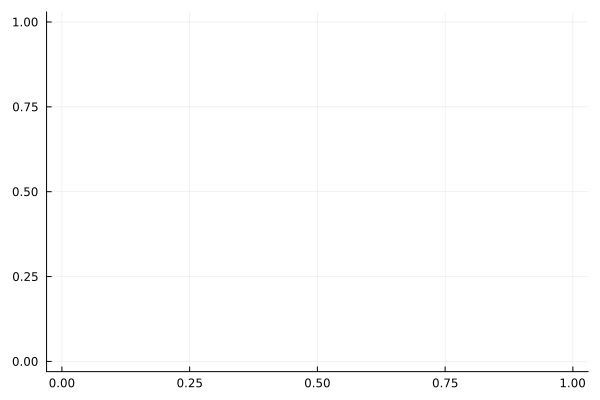

In [83]:
_, opt, samples = optimize_by_walking1(jump_model, NN_model, init_U, init_L; return_sampled=true);
solutions = filter(v -> !iszero(v), samples)
scatter(first.(solutions), last.(solutions), legend=false)

In [84]:
samples

1-element Vector{Vector}:
 [0.0, 0.0]

In [85]:
opt, samples

([14.24389279296874], Vector[[0.0, 0.0]])

In [77]:
solutions

1-element Vector{Float64}:
 14.24389279296874

In [78]:
samples

1-element Vector{Float64}:
 14.24389279296874

In [ ]:
contourf(x_range, y_range, (x, y) -> NN_model(hcat(x, y)')[], c=cgrad(:viridis), lw=0)
samples = QuasiMonteCarlo.sample(10, init_L, init_U, LatinHypercubeSample());

i = 1

if isdir("frames")
    rm("frames", recursive=true)
end

mkdir("frames")

for sample in eachcol(samples)
    plotd = scatter!([sample[1]], [sample[2]], legend=false, color=:blue)
    savefig(plotd,"frames/frame_$i.png")
    i+=1
    res = local_search(sample, jump_model, init_U, init_L)
    plotd = scatter!([res[1]], [res[2]], legend=false, color=:red)
    savefig(plotd,"frames/frame_$i.png")
    i+=1
end

# Load images
image_files = ["frames/frame_$j.png" for j in 1:i-1]
images = [load(file) for file in image_files]
# Create and save the GIF
save("animation_2.gif", cat(images..., dims=3))

rm("frames", recursive=true)


![alt text](animation_2.gif)